# Denoising Autoencoder with Adversarial Training

In [0]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Fri Dec  7 17:46:55 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip3 install torch==0.4.1
!pip3 install torchvision==0.2.1
!pip3 install Pillow==4.0.0
!pip3 install scipy
!pip3 install numpy
!pip3 install matplotlib

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd.variable import Variable
import torch.nn.functional as F
import numpy as np
import os

# Configuration
Arguments and configuration variables for training. Plese change them depending on your needs

In [0]:
# Configs
BATCH_SIZE = 20
NUM_EPOCH = 10 # Max number of epoch
LEARNING_RATE_G = 0.0002 # Change it depending on your generator model and optimizer_g
LEARNING_RATE_D = 0.0002 # Change it depending on your generator model and optimizer_g
CUDA = True # True => use gpu if it is available | False => use cpu
OUTPUT_PATH = '/PATH/outputs/dae_gan' # location for image outputs
MODEL_PATH = '/PATH/model/dae_gan' # location for checkpoints

In [0]:
# Apply configs
device = torch.device('cuda' if torch.cuda.is_available() and CUDA else 'cpu')
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH)
if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)

# DATASET
You can download CelebA dataset from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# Train: 20000
# Eval : 5000
Batch size torch.Size([20, 3, 128, 128])
Intensity distribution [min:0.000000, max:1.000000] [mean:0.455938, std:0.297268]


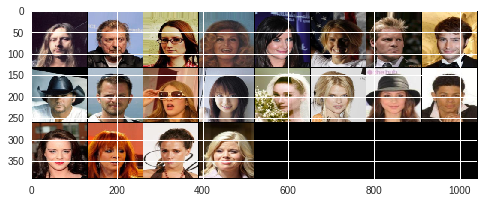

In [4]:
# Dataset preparation
xform = transforms.Compose([
    torchvision.transforms.Resize([128,128]),
    transforms.ToTensor()
])

# Read dataset
dset = torchvision.datasets.ImageFolder('/YOUR_CELEBA_PATH', transform=xform)

# Split dataset into train and evalution sets
train_size = int(0.8 * len(dset))
test_size = len(dset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dset, [train_size, test_size])

# Create dataset loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('# Train: {}'.format(len(train_dataset)))
print('# Eval : {}'.format(len(eval_dataset)))

# Check that images are successfully loaded and displayed
def show(img):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
# Train set
dataiter = iter(train_loader)
img, _ = dataiter.next()
print('Batch size', img.size())
print('Intensity distribution [min:{:2f}, max:{:2f}] [mean:{:2f}, std:{:2f}]'
      .format(img.min().item(), img.max().item(), img.mean().item(), img.std().item()))
show(img)

# Autoencoder Architecture (Generator)
Autoencoder architecture will be used as a generator in the adversarial training setting.

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        n_features = 128
        n_out = 128
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(    
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Discriminator Architecture
- It takes real and generated (=fake) images and returns binary classification output

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 128
        n_out = 128
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [0]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.REAL_LABEL=1.0
        self.FAKE_LABEL=0.0
        self.fake_cache = None
        self.real_cache = None
        self.discriminator_loss = nn.BCELoss()
        
    def __call__(self, x, isreal):
        if isreal:
            if (self.real_cache is None) or (x.numel() != self.real_cache.numel()):
                self.real_cache = x.new_full(x.size(), self.REAL_LABEL, requires_grad=False)
                self.real_cache.to(x.device)
            target = self.real_cache
        else:
            if (self.fake_cache is None) or (x.numel() != self.fake_cache.numel()):
                self.fake_cache = x.new_full(x.size(), self.FAKE_LABEL, requires_grad=False)
                self.fake_cache.to(x.device)
            target = self.fake_cache

        return self.discriminator_loss(x, target)

In [0]:
# Create Denoising Autoencoder, an optimizer and reconstruction loss
G = AutoEncoder().to(device)
D = Discriminator().to(device)
optimizer_g = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE_G)
optimizer_d = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE_D)
reconstruction_loss = nn.MSELoss()
gan_loss = GANLoss()

# Training
- Generate the noisy input (xhat = x + noise)
    - Generate a noise matrix
    - Add noise to images in order to obtain noisy input
- Generator forward pass (y = G(xhat))
    - Give noisy images to the generator as inputs
- Discrimiator forward pass
    - Give real images to the discriminator as inputs (p_real = D(x))
    - Give fake images to the discriminator as inputs (p_fake = D(y))
- Discriminator backward pass
    - Calculate loss for discriminator
    - Do necessary operations for backpropagation
- Generator backward pass
    - Calculate reconstruction loss (MSE loss) between fake and real images
    - Calculate adversarial loss for generator by using output of discriminator p_fake
    - Sum reconstruction loss and adversarial loss (Hint: use 0.995 * reconstruction_loss + 0.005 * adversarial_loss formula)
    - Do necessary operations for backpropagation
    
- Collect your loss values in a container (e.g. list, dictionary, etc.) for plotting
- Return avarage_g_loss and total_d_loss
- Save your model weights regularly.

In [0]:
# Complete the training function. 
# This method is called for each epoch with epoch id. 
# It returns avarage training loss for generator and discriminator networks
def train(epoch):
    G.train()
    D.train()
    total_g_loss = 0.0
    total_d_loss = 0.0
    for i, (img, _) in enumerate(train_loader):
        # Create noise matrix for each sample in the batch.
        #img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
  
        # Add noise to the ground truth image to obtain noisy input
        noisy_img = Variable(noisy_img).cuda()
        img = Variable(img).cuda()
        # Generator forward pass
        output = G(noisy_img)
        # Discrimiator forward pass
        
        #loss = gan_loss(output, img)
        #MSE_loss = reconstruction_loss(output, img)
        
    
        optimizer_d.zero_grad()

        # Train Real Data
        d_prediction_real = D(img)
        d_error_real = gan_loss(d_prediction_real, 1 )
        #d_error_real.backward(retain_graph=True )
        # Train Fake Data
        d_prediction_fake = D(output)
        d_error_fake = gan_loss(d_prediction_fake, 0 )
        #d_error_fake.backward(retain_graph=True )

        d_loss = (0.5 * d_error_real) + (0.5 * d_error_fake)
        d_loss.backward(retain_graph=True)
        optimizer_d.step()
        

        # Generator backward pass
        optimizer_g.zero_grad()
        g_prediction_fake = D(output)
        error = reconstruction_loss(output, img)
        g_error_fake = gan_loss(d_prediction_fake, 0 )
        #error.backward(retain_graph=True )
        #g_error_fake.backward()
        
        g_loss = (0.995 * error) + (0.005 * g_error_fake) 
        g_loss.backward()
        optimizer_g.step()
        

        # Update total losses
        total_d_loss = total_d_loss + d_loss.item()
        total_g_loss = total_g_loss + g_loss.item()
        
        # Print logs
        if i % 50 == 0:
            print('[{0:3d}/{1}] {2:3d}/{3} loss_g: {4:.4f} | loss_d: {5:4f}'
                .format(epoch+1, NUM_EPOCH, i+1, len(train_loader), g_loss.item(), d_loss.item()))

        # Merge noisy input, ground truth and network output so that you can compare your results side by side
        # You can check your output images which is saved in ./outputs/dae/
        if i % 100 == 0:
            out = torch.cat([noisy_img, img, output], dim=3).detach().cpu().clamp(0.0, 1.0)
            vutils.save_image(out, '{}/{}_dae_gan_output.png'.format(OUTPUT_PATH, epoch, i), normalize=True)
            vutils.save_image(out, '{}/{}_{}.png'.format(OUTPUT_PATH, epoch, i), normalize=True)
            show(out)
    
    # Save your model weights
    if (epoch + 1) % 10 == 0:
        save_dict = {
            'g':G.state_dict(), 
            'g_optim':optimizer_g.state_dict(),
            'd': D.state_dict(),
            'd_optim': optimizer_d.state_dict()
        }
        torch.save(save_dict, '{}/dae_gan_{}.pth.tar'.format(MODEL_PATH, epoch+1))
    
    # Calculate avarage loss for the current epoch
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    print('Epoch[{}] Training Loss G: {:4f} | D: {:4f}'.format(epoch+1, avg_g_loss, avg_d_loss))
    
    return avg_g_loss, avg_d_loss


# Evaluation
* Check your network performance on evaluation set
- Generate noisy input
- Generator forward pass
- Discrimiator forward pass
- Calculate avarage loss and return

In [0]:
# Complete the evaluation function. 
# This method is called for each epoch with epoch id. 
# It returns avarage evaluation loss for generator and discriminator networks
def evaluate(epoch):
    with torch.no_grad():
      G.eval()
      D.eval()
      total_g_loss = 0.0
      total_d_loss = 0.0
      for i, (img, _) in enumerate(eval_loader):
          # Create noise matrix for each sample in the batch.
          #img = img.view(img.size(0), -1)
          noise = torch.randn(img.size()) * 0.2
          #noise = np.random.normal(0, 0.1, img_size)
          noisy_img = img + noise

          # Add noise to the ground truth image to obtain noisy input
          noisy_img = Variable(noisy_img).cuda()
          img = Variable(img).cuda()

          # Generator forward pass
          output = G(noisy_img)

          # Discrimiator forward pass

          optimizer_d.zero_grad()

          d_prediction_real = D(img)
          d_prediction_fake = D(output)

          # Calculate total loss for D
          d_error_real = gan_loss(d_prediction_real, 1 )
          d_error_fake = gan_loss(d_prediction_fake, 0 )
          d_loss = (0.5 * d_error_real) + (0.5 * d_error_fake)

          # Calculate total loss for G
          optimizer_g.zero_grad()
          g_prediction_fake = D(output)
          error = reconstruction_loss(output, img)
          g_error_fake = gan_loss(d_prediction_fake, 0 )

          g_loss = (0.995 * error) + (0.005 * g_error_fake) 

          # Update total losses
          total_d_loss = total_d_loss + d_loss.item()
          total_g_loss = total_g_loss + g_loss.item()

      avg_g_loss = total_g_loss / len(eval_loader)
      avg_d_loss = total_d_loss / len(eval_loader)
      print('Epoch[{}] Evaluation Loss G: {:4f} | D: {:4f}'.format(epoch+1, avg_g_loss, avg_d_loss))

      return avg_g_loss, avg_d_loss


# Experiments
- Start training. 
- At each epoch calculate avarage training and avarage evalauation loss and store them in a container (e.g. list, dictionary, etc.)

[  1/10]   1/1000 loss_g: 0.2613 | loss_d: 0.693725
[  1/10]  51/1000 loss_g: 0.0340 | loss_d: 0.685238
[  1/10] 101/1000 loss_g: 0.0241 | loss_d: 0.354911
[  1/10] 151/1000 loss_g: 0.0201 | loss_d: 0.229683
[  1/10] 201/1000 loss_g: 0.0122 | loss_d: 0.055498
[  1/10] 251/1000 loss_g: 0.0114 | loss_d: 0.050691
[  1/10] 301/1000 loss_g: 0.0101 | loss_d: 0.037471
[  1/10] 351/1000 loss_g: 0.0116 | loss_d: 0.025228
[  1/10] 401/1000 loss_g: 0.0102 | loss_d: 0.023353
[  1/10] 451/1000 loss_g: 0.0080 | loss_d: 0.020678
[  1/10] 501/1000 loss_g: 0.0101 | loss_d: 0.023716
[  1/10] 551/1000 loss_g: 0.0080 | loss_d: 0.012451
[  1/10] 601/1000 loss_g: 0.0090 | loss_d: 0.020121
[  1/10] 651/1000 loss_g: 0.0090 | loss_d: 0.024873
[  1/10] 701/1000 loss_g: 0.0095 | loss_d: 0.005706
[  1/10] 751/1000 loss_g: 0.0083 | loss_d: 0.018656
[  1/10] 801/1000 loss_g: 0.0075 | loss_d: 0.013702
[  1/10] 851/1000 loss_g: 0.0079 | loss_d: 0.018775
[  1/10] 901/1000 loss_g: 0.0081 | loss_d: 0.009512
[  1/10] 951

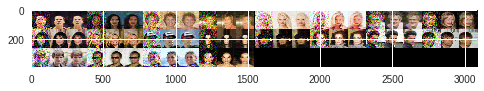

In [11]:
cache_train_g = []
cache_eval_g = []
cache_train_d = []
cache_eval_d = []
for epoch in range(NUM_EPOCH):
    avg_train_g_loss, avg_train_d_loss = train(epoch)
    avg_eval_g_loss, avg_eval_d_loss = evaluate(epoch)
    
    # store training and evaluation loss for plotting
    cache_train_g.append(avg_train_g_loss)
    cache_eval_g.append(avg_eval_g_loss)
    cache_train_d.append(avg_train_d_loss)
    cache_eval_d.append(avg_eval_d_loss)

# Plot Loss Curves and Discuss
- Stored training and evaluation losses are used to plot loss curves.
- A few generated test image results and corresponding original images are given.

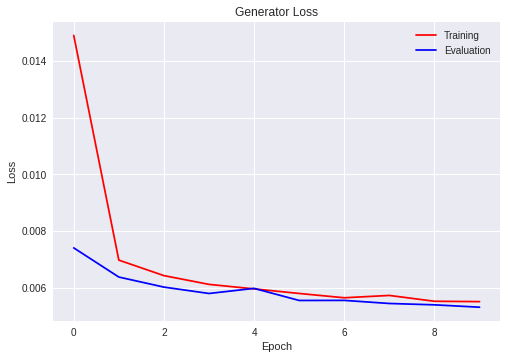

In [12]:
'''
When the model converge, the differences reconstruction losses and gan losses converge to zero.
In progess, more precise denoising pictures are produced.
As it paper say: After several steps of training, if G and D have enough capacity, they will reach a
point at which both cannot improve because pg = pdata. The discriminator is unable to differentiate between
the two distributions
'''
# Plot Generator Loss (Training vs Evaluation)
plt.plot(
    cache_train_g, 'r', 
    cache_eval_g, 'b')
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Evaluation'])
plt.show()

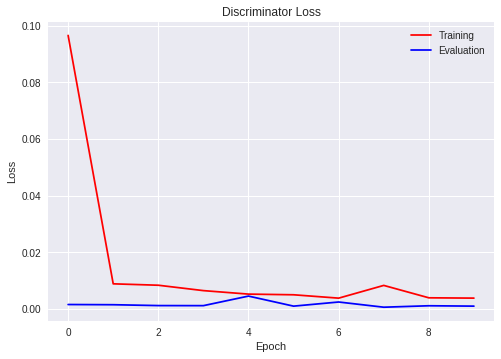

In [13]:
# Plot Discriminator Loss (Training vs Evaluation)

plt.plot(
    cache_train_d, 'r', 
    cache_eval_d, 'b')
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Evaluation'])
plt.show()

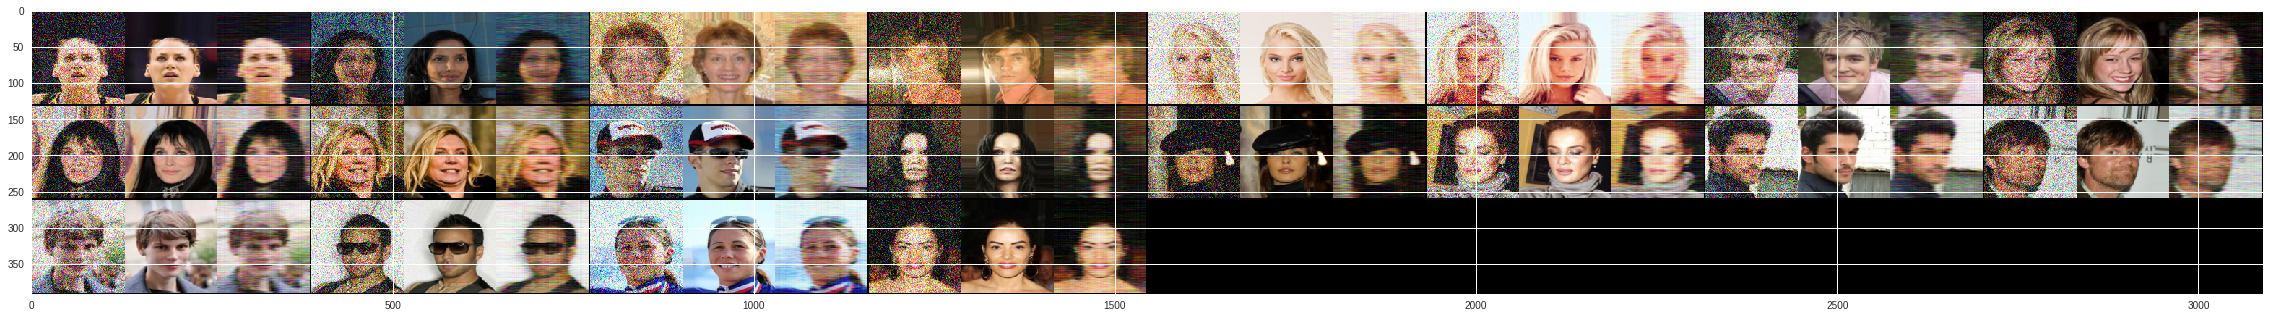

In [14]:
from skimage import io

image = io.imread(OUTPUT_PATH + '/9_dae_gan_output.png')
plt.figure(figsize=(40,40))
plt.imshow(image)
